# Workflow For Designing Closed Loop Systems

PID Feedback Architecture

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

State Feedback Architecture (without disturbance and noise)

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

This notebook develops closed loop systems for SBML models to elucidate the underlying workflow.

# Issues

1. Filter for full state feedback

# Preliminaries

## Imports

In [2]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Constants

In [4]:
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
BIOMD206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

# Antimony Model

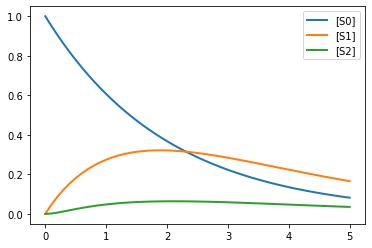

In [4]:
ANT_MODEL = """
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

S0 = 0
S1 = 0
S2 = 0
S3 = 0
k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(ANT_MODEL)
rr["S0"] = 1
rr.simulate()
rr.plot()

# Model of Glycoytic Oscillations (BioModels 206)

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

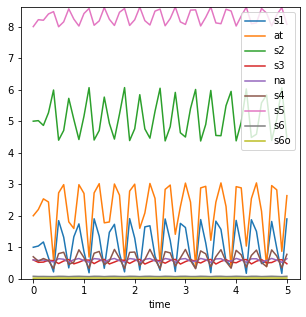

In [5]:
ctlsb = ctl.ControlSBML(BIOMD206)
ctlsb.plotTrueModel(figsize=(5,5))

# Analysis Workflow

## Step 1: Create Analysis Objects

In [6]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
siso = ctl.SISOClosedLoopSystem(ctlsb)

## Step 2: Evaluate Controllability

In [7]:
siso.evaluateControllability(range(5))

{0:           S1        S2
 S0  0.833333  0.166667,
 1:           S1        S2
 S0  0.833333  0.166667,
 2:           S1        S2
 S0  0.833333  0.166667,
 3:           S1        S2
 S0  0.833333  0.166667,
 4:           S1        S2
 S0  0.833333  0.166667}

## Step 3A: Evaluate PID Closed Loop System

In [6]:
def evaluateClosedLoopSystem(ctlsb, is_plot=True, cl_opts={}, plt_opts={}, sim_opts={},
                method=ctl.SISOClosedLoopSystem.makePIDClosedLoopSystem):
    """
    Evaluate a PID controller by plotting step response.
    
    Parameters
    ----------
    cl_opts: dict
        Options for the closed loop system. See parameters for SISOClosedLoopSystem.makePIDClosedLoopSystem
    plt_opts: dict
        Options for plottling. See ctl.plotOneTs
    sim_opts: dict
        Options for simulation
            start_time: float
            end_time: float
            points_per_time: int
    """
    siso = ctl.SISOClosedLoopSystem(ctlsb)
    # Handle the method to call
    extracted_method = method.__qualname__.split(".")[1]
    stmt = "siso.%s(**cl_opts)" % extracted_method
    eval(stmt)
    ts = siso.makeStepResponse(**sim_opts)
    titles = ["%s=%s" % (k, v) for k, v in cl_opts.items()]
    title = ", ".join(titles)
    if is_plot:
        ctl.plotOneTS(ts, figsize=(5, 5), title=title)
    return ts

# Tests
cl_opts=dict(kp=1000, ki=10, kd=0, kf=-0.001, noise_amp=0.1, noise_frq=20)
sim_opts = dict(end_time=7)
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
ts = evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, is_plot=False)
assert("Timeseries" in str(type(ts)))
print("OK!")

NameError: name 'ANT_MODEL' is not defined

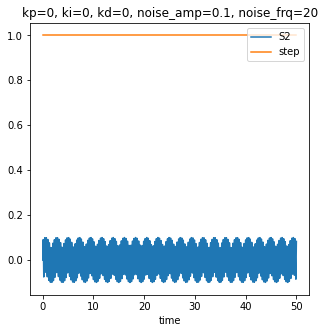

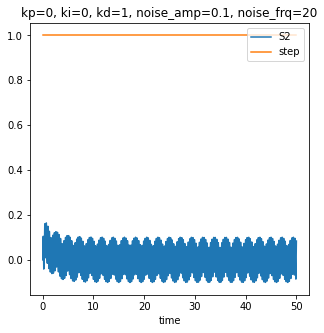

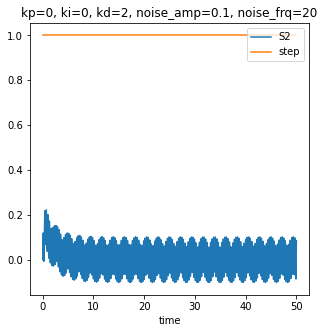

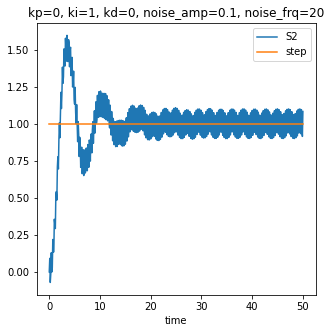

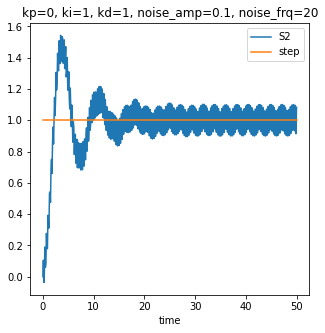

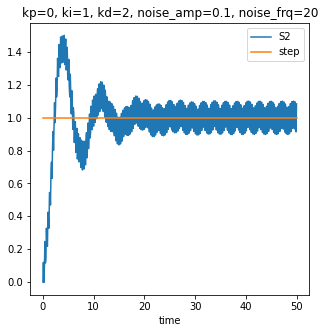

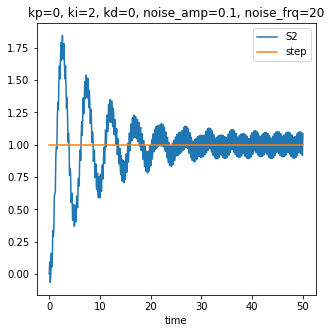

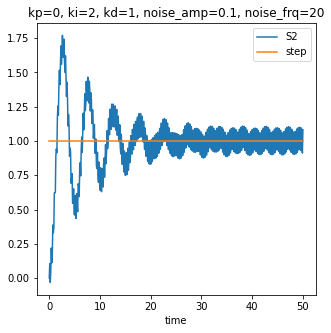

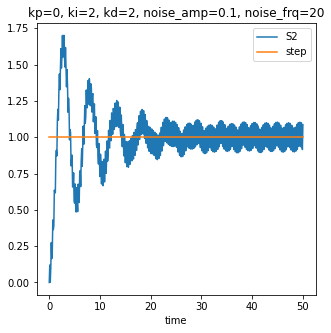

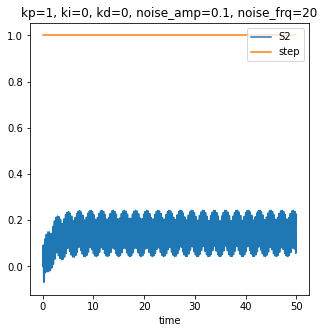

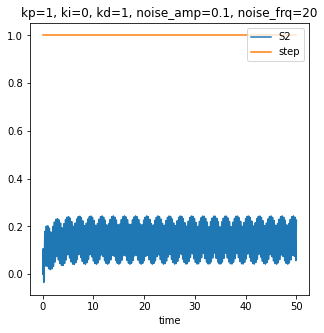

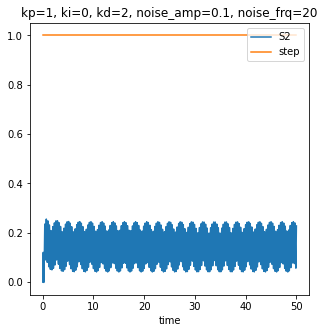

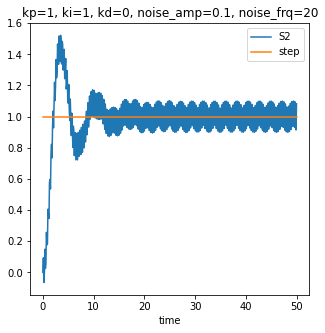

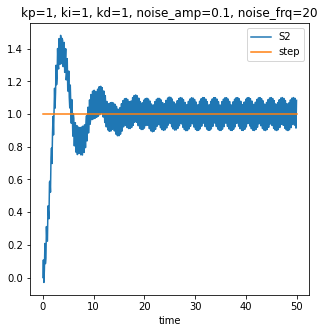

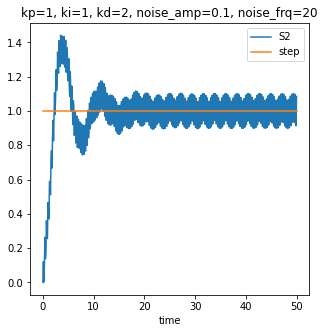

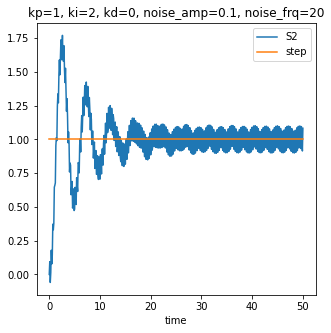

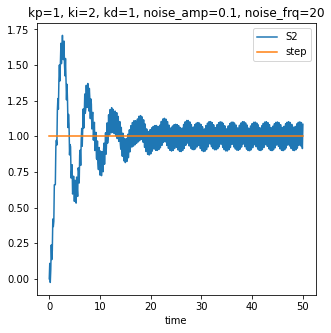

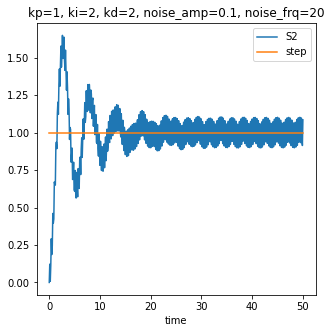

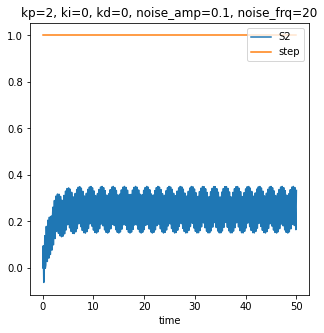

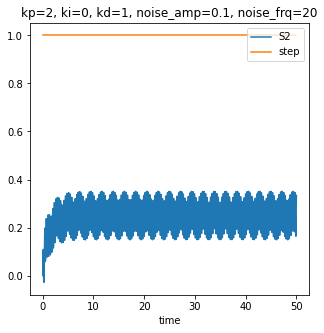

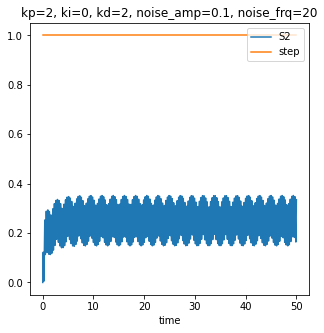

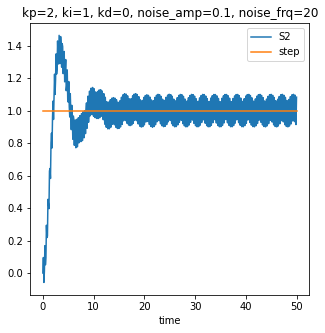

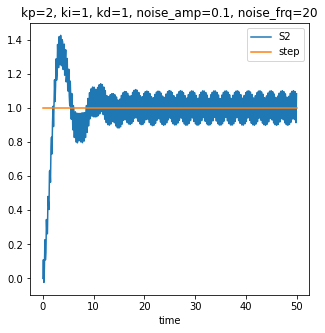

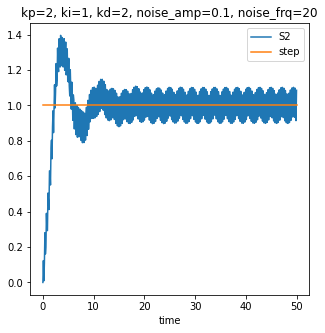

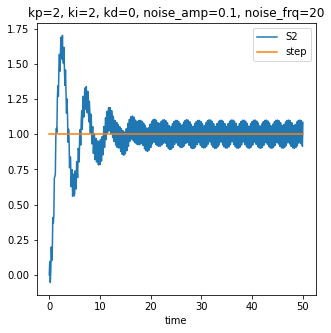

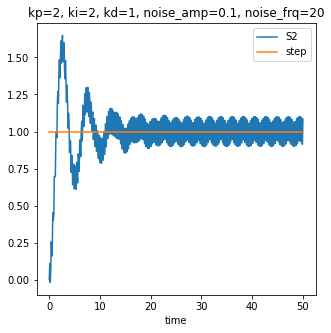

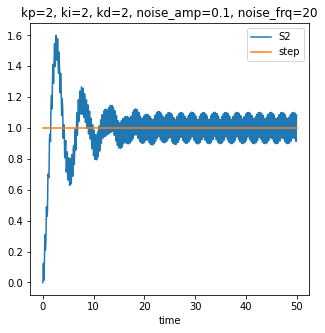

In [11]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
for kp in range(0, 3):
    for ki in range(0, 3):
        for kd in range(0, 3):
            cl_opts = dict(kp=kp, ki=ki, kd=kd, noise_amp=0.1, noise_frq=20)
            sim_opts = dict(end_time=50)
            evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts)

## Step 3B: Evaluate Full State Closed Loop System

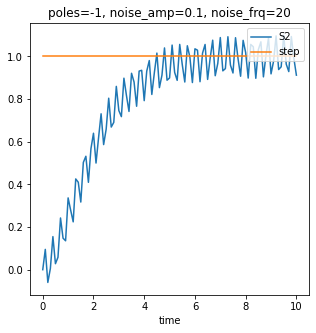

In [12]:
cl_opts=dict(poles=-1, noise_amp=0.1, noise_frq=20)
method = ctl.SISOClosedLoopSystem.makeFullStateClosedLoopSystem
sim_opts = dict(end_time=10)
ts = evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, method=method)

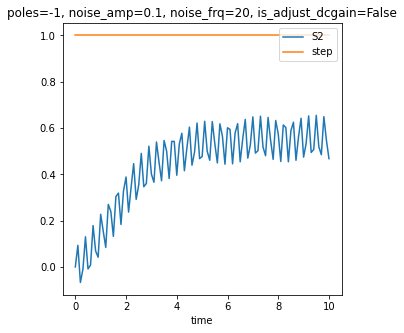

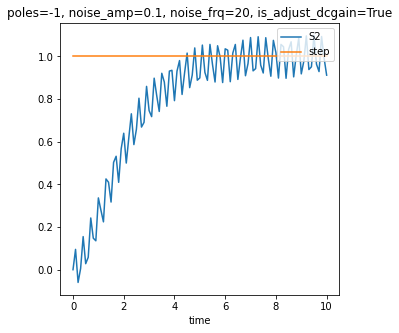

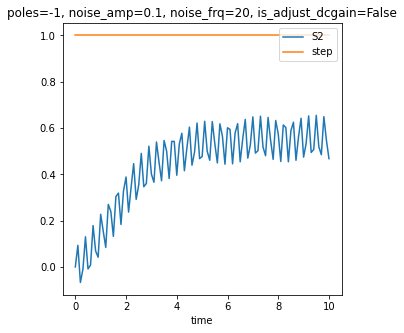

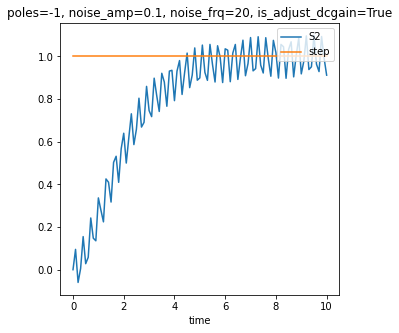

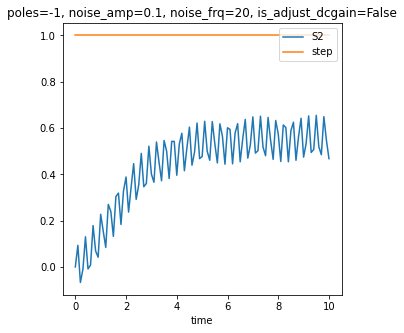

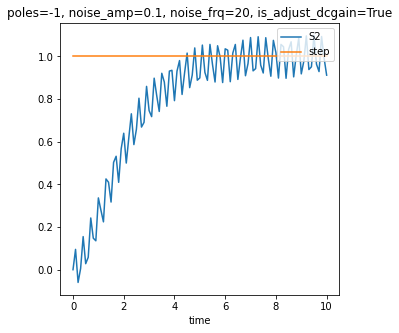

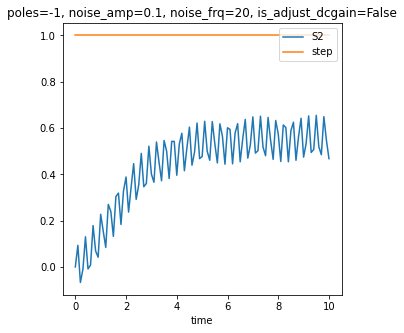

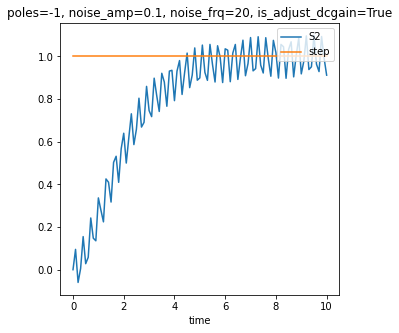

In [13]:
sim_opts = dict(end_time=10)
cl_opts=dict(poles=-1, noise_amp=0.1, noise_frq=20)
for pole in [-1, -2, -4, -8]:
    for is_adjust_dcgain in [False, True]:
        cl_opts["is_adjust_dcgain"] = is_adjust_dcgain
        evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, method=method)

# Glycolytic Oscillations

In [9]:
ctlsb = ctl.ControlSBML(BIOMD206, input_names=["at"], output_names=["s5"])
cl_opts=dict(kp=1, noise_amp=0, noise_frq=20)
method = ctl.SISOClosedLoopSystem.makePIDClosedLoopSystem
sim_opts = dict(end_time=1, step_size=6)
ts = evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, method=method)

IndexError: index 3 is out of bounds for axis 1 with size 3